In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/dataset/'

In [ ]:
from torch.utils.data import Dataset
import os
from sklearn.preprocessing import LabelEncoder

In [ ]:
class PointDataset(Dataset):
  def __init__(self, path=path, transform=None):
    self.path = path
    points = os.listdir(self.path)
    self.samples = np.concatenate([[os.path.join(p, i) for i in os.listdir(self.path + p)] for p in points])
    if transform is None:
      self.should_transform = False
    else:
      self.transform = transform
      self.should_transform = True

  def __len__(self):
    return self.samples.size
  
  def __getitem__(self, idx):
    color = self.samples[idx][0]
    if color == "w":
      target = 0
    elif color == "b":
      target = 1
    else:
      target = 2
    img_path = os.path.join(self.path,  self.samples[idx])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if self.should_transform:
      img = self.transform(img)
    return img, target

In [ ]:
dataset = PointDataset(transform=transforms.Compose([       
                        transforms.ToTensor(),
                        transforms.Resize((32, 32)),
                        transforms.Normalize((0.5,), (0.5,))
                    ]))

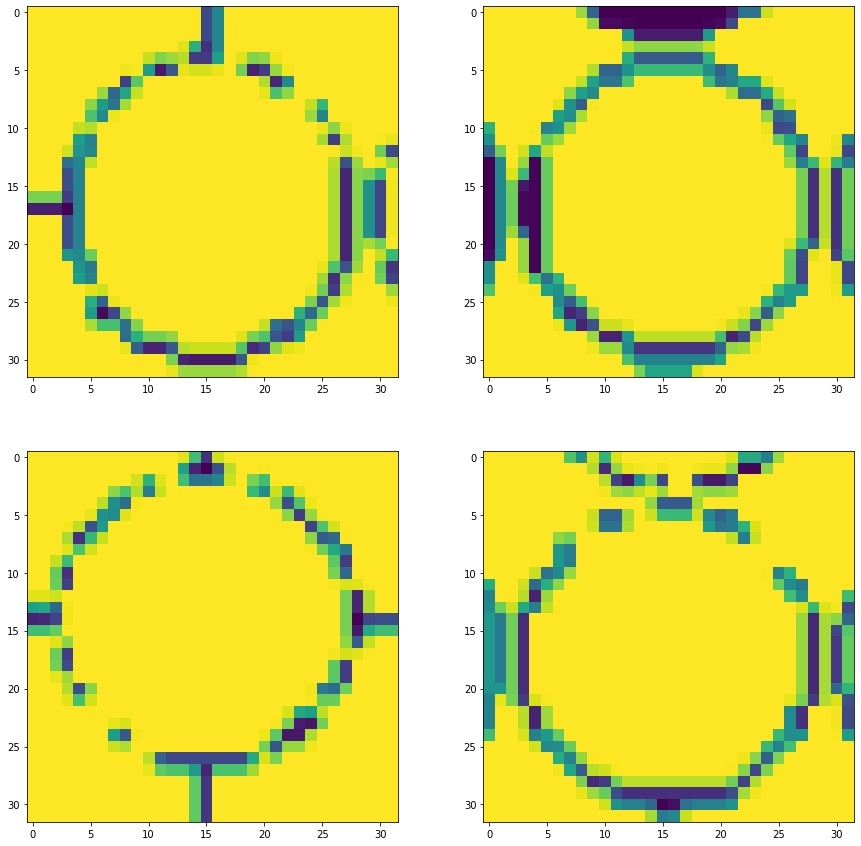

In [ ]:
i = 0
plt.figure(figsize=(15, 15))
for img, target in dataset:
    i +=1
    plt.subplot(2, 2, i)
    plt.imshow(img[0])
    if i == 4:
      break
plt.show()

In [ ]:
no_cuda  = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

In [ ]:
print(len(dataset))

6602


In [ ]:
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
print(train_size, test_size)

4951 1651


In [ ]:
batch_size = 16
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, **kwargs)

In [ ]:
def train(model, device, train_loader, optimizer, epoch, log_interval, loss_archive):
    train_loss = 0

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target, weight=torch.tensor([1., 1., 1.], device=device))
        loss.backward()
        optimizer.step()

        train_loss += loss.item ()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    train_loss = train_loss / len(train_loader)
    loss_archive.append (train_loss)

def test(model, device, test_loader, loss_archive):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss #
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = test_loss / len(test_loader)
    loss_archive.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(2048, 3)

    def forward(self, x):
        #torch.Size([1, 32, 32])
        x = self.conv1(x)
        x = F.relu(x)

        #torch.Size([16, 32, 32])
        x = self.conv2(x)
        x = F.relu(x)
        
        #torch.Size([32, 32, 32])
        x = F.max_pool2d(x, 4)

        #torch.Size([32, 8, 8]))

        x = torch.flatten(x, 1)
        
        #torch.Size([2048])
        x = self.fc1(x)
        output = F.log_softmax(x, dim=1)
        
        #torch.Size([3])
        return output

In [ ]:
from torch.optim.lr_scheduler import StepLR

Train Epoch: 1 [0/4951 (0%)]	Loss: 1.101133
Train Epoch: 1 [160/4951 (3%)]	Loss: 0.055793
Train Epoch: 1 [320/4951 (6%)]	Loss: 0.083683
Train Epoch: 1 [480/4951 (10%)]	Loss: 0.020948
Train Epoch: 1 [640/4951 (13%)]	Loss: 0.029049
Train Epoch: 1 [800/4951 (16%)]	Loss: 0.000998
Train Epoch: 1 [960/4951 (19%)]	Loss: 0.003106
Train Epoch: 1 [1120/4951 (23%)]	Loss: 0.000554
Train Epoch: 1 [1280/4951 (26%)]	Loss: 0.048043
Train Epoch: 1 [1440/4951 (29%)]	Loss: 0.024683
Train Epoch: 1 [1600/4951 (32%)]	Loss: 0.000400
Train Epoch: 1 [1760/4951 (35%)]	Loss: 0.000364
Train Epoch: 1 [1920/4951 (39%)]	Loss: 0.002575
Train Epoch: 1 [2080/4951 (42%)]	Loss: 0.022983
Train Epoch: 1 [2240/4951 (45%)]	Loss: 0.000096
Train Epoch: 1 [2400/4951 (48%)]	Loss: 0.000094
Train Epoch: 1 [2560/4951 (52%)]	Loss: 0.007382
Train Epoch: 1 [2720/4951 (55%)]	Loss: 0.010185
Train Epoch: 1 [2880/4951 (58%)]	Loss: 0.000447
Train Epoch: 1 [3040/4951 (61%)]	Loss: 0.000218
Train Epoch: 1 [3200/4951 (65%)]	Loss: 0.000150
Trai

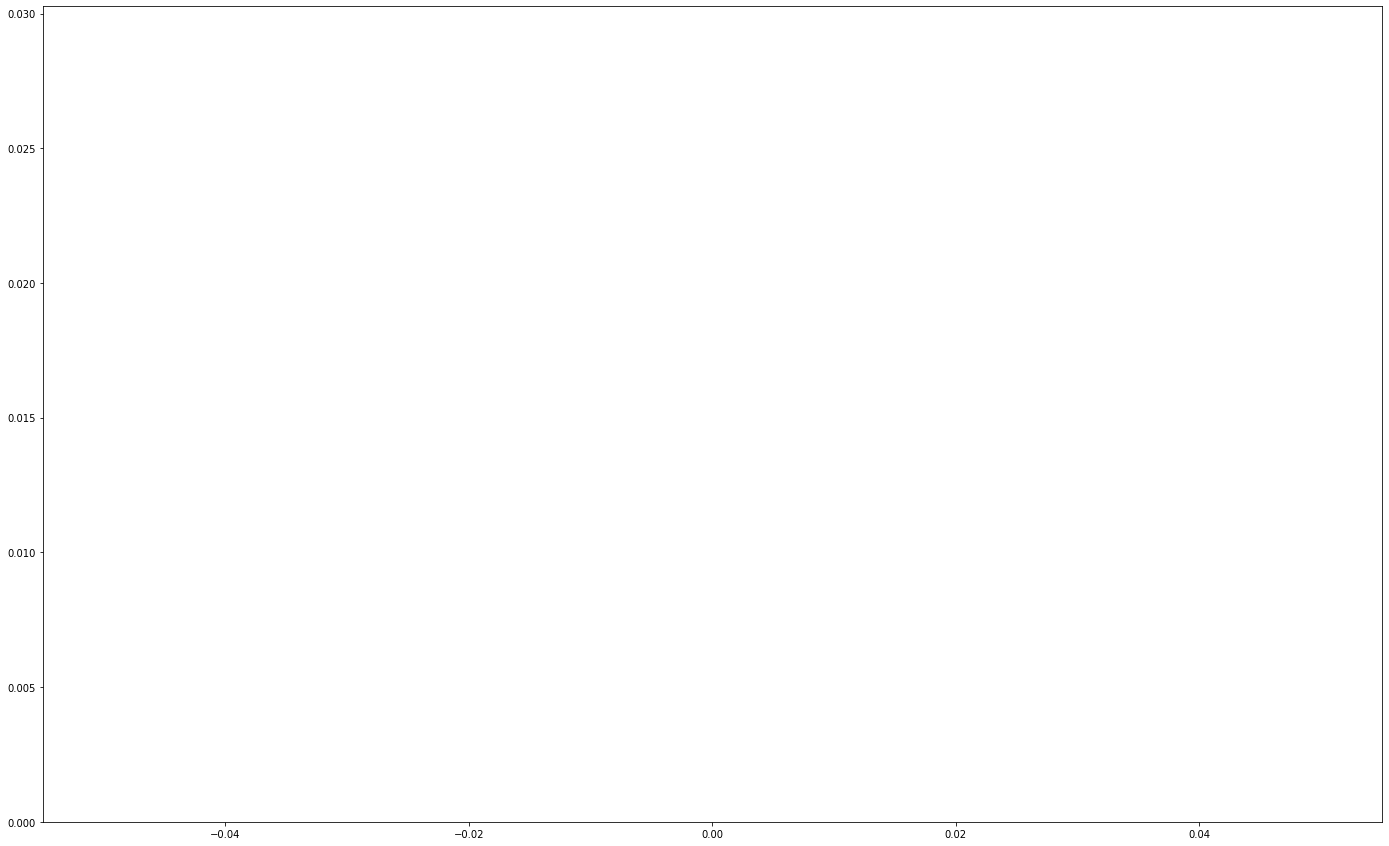

Train Epoch: 2 [0/4951 (0%)]	Loss: 0.000030
Train Epoch: 2 [160/4951 (3%)]	Loss: 0.000002
Train Epoch: 2 [320/4951 (6%)]	Loss: 0.000191
Train Epoch: 2 [480/4951 (10%)]	Loss: 0.000002
Train Epoch: 2 [640/4951 (13%)]	Loss: 0.000387
Train Epoch: 2 [800/4951 (16%)]	Loss: 0.000012
Train Epoch: 2 [960/4951 (19%)]	Loss: 0.000066
Train Epoch: 2 [1120/4951 (23%)]	Loss: 0.000005
Train Epoch: 2 [1280/4951 (26%)]	Loss: 0.000024
Train Epoch: 2 [1440/4951 (29%)]	Loss: 0.000066
Train Epoch: 2 [1600/4951 (32%)]	Loss: 0.000013
Train Epoch: 2 [1760/4951 (35%)]	Loss: 0.000011
Train Epoch: 2 [1920/4951 (39%)]	Loss: 0.000600
Train Epoch: 2 [2080/4951 (42%)]	Loss: 0.157746
Train Epoch: 2 [2240/4951 (45%)]	Loss: 0.000116
Train Epoch: 2 [2400/4951 (48%)]	Loss: 0.000013
Train Epoch: 2 [2560/4951 (52%)]	Loss: 0.000001
Train Epoch: 2 [2720/4951 (55%)]	Loss: 0.000048
Train Epoch: 2 [2880/4951 (58%)]	Loss: 0.000123
Train Epoch: 2 [3040/4951 (61%)]	Loss: 0.000003
Train Epoch: 2 [3200/4951 (65%)]	Loss: 0.000005
Trai

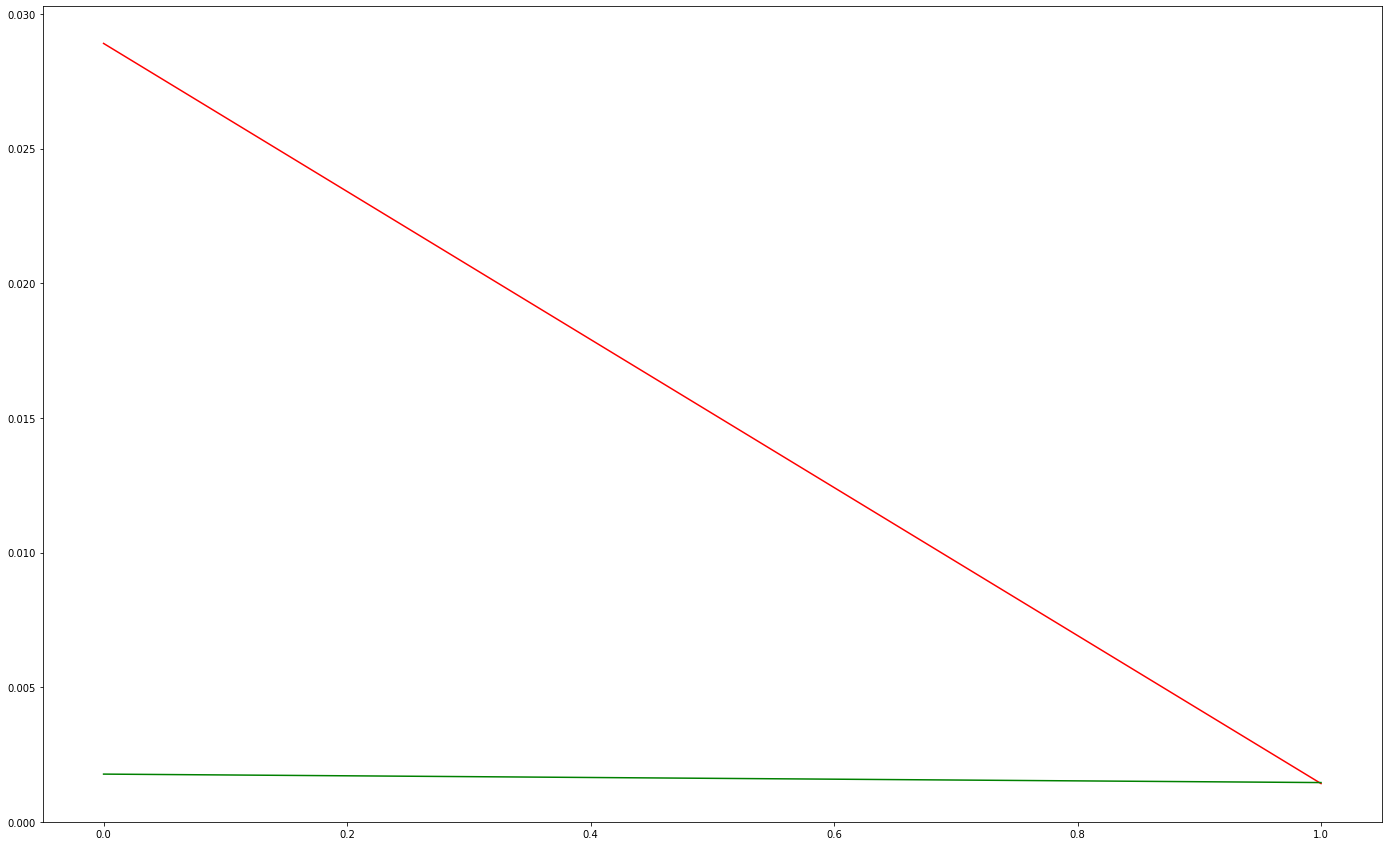

Train Epoch: 3 [0/4951 (0%)]	Loss: 0.000081
Train Epoch: 3 [160/4951 (3%)]	Loss: 0.000049
Train Epoch: 3 [320/4951 (6%)]	Loss: 0.000005
Train Epoch: 3 [480/4951 (10%)]	Loss: 0.000031
Train Epoch: 3 [640/4951 (13%)]	Loss: 0.000015
Train Epoch: 3 [800/4951 (16%)]	Loss: 0.000023
Train Epoch: 3 [960/4951 (19%)]	Loss: 0.000032
Train Epoch: 3 [1120/4951 (23%)]	Loss: 0.000013
Train Epoch: 3 [1280/4951 (26%)]	Loss: 0.000013
Train Epoch: 3 [1440/4951 (29%)]	Loss: 0.000023
Train Epoch: 3 [1600/4951 (32%)]	Loss: 0.000527
Train Epoch: 3 [1760/4951 (35%)]	Loss: 0.000106
Train Epoch: 3 [1920/4951 (39%)]	Loss: 0.000026
Train Epoch: 3 [2080/4951 (42%)]	Loss: 0.000014
Train Epoch: 3 [2240/4951 (45%)]	Loss: 0.000007
Train Epoch: 3 [2400/4951 (48%)]	Loss: 0.000079
Train Epoch: 3 [2560/4951 (52%)]	Loss: 0.000006
Train Epoch: 3 [2720/4951 (55%)]	Loss: 0.000118
Train Epoch: 3 [2880/4951 (58%)]	Loss: 0.000019
Train Epoch: 3 [3040/4951 (61%)]	Loss: 0.000011
Train Epoch: 3 [3200/4951 (65%)]	Loss: 0.000019
Trai

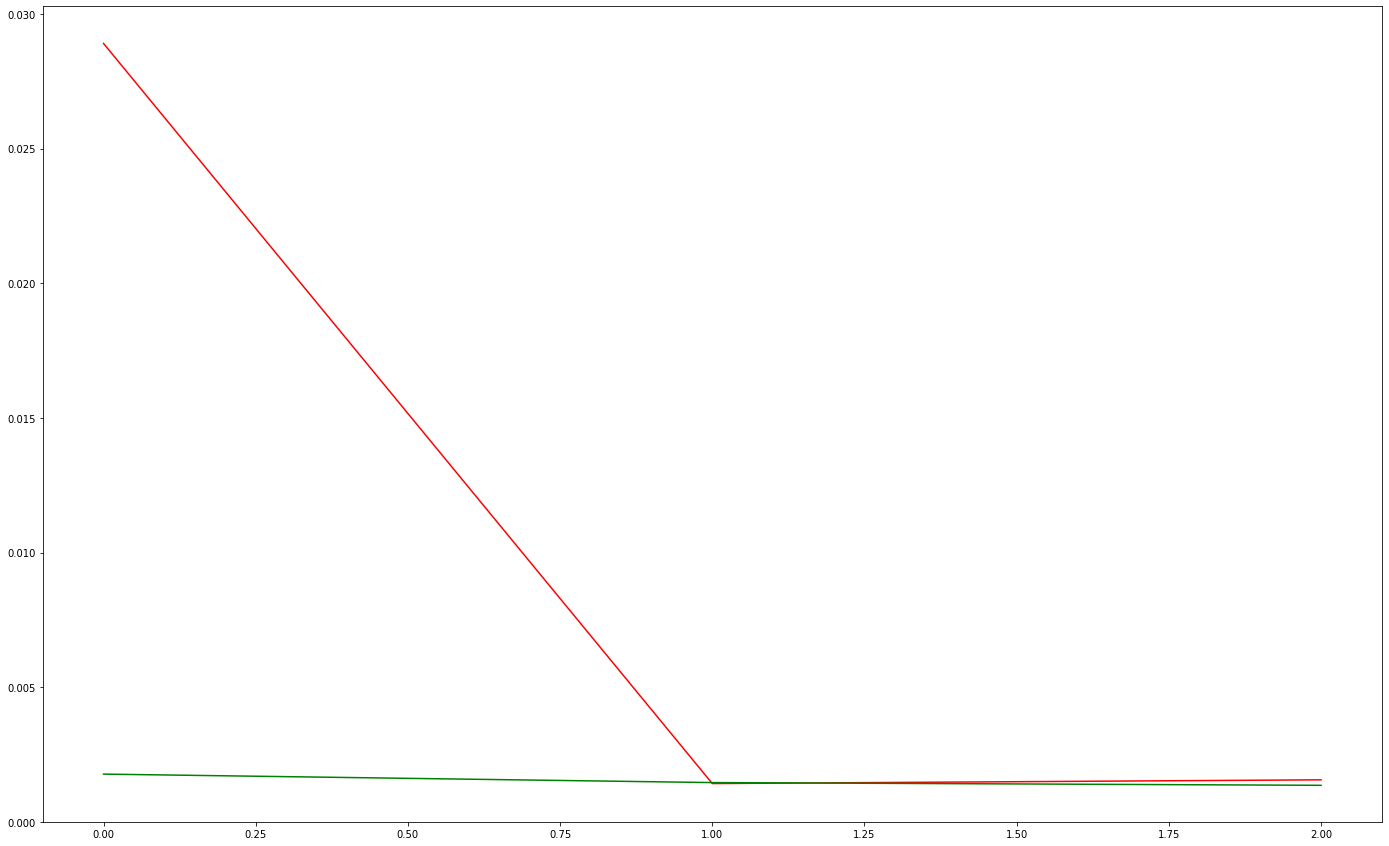

Train Epoch: 4 [0/4951 (0%)]	Loss: 0.000015
Train Epoch: 4 [160/4951 (3%)]	Loss: 0.000008
Train Epoch: 4 [320/4951 (6%)]	Loss: 0.000019
Train Epoch: 4 [480/4951 (10%)]	Loss: 0.000049
Train Epoch: 4 [640/4951 (13%)]	Loss: 0.000048
Train Epoch: 4 [800/4951 (16%)]	Loss: 0.000003
Train Epoch: 4 [960/4951 (19%)]	Loss: 0.000197
Train Epoch: 4 [1120/4951 (23%)]	Loss: 0.000052
Train Epoch: 4 [1280/4951 (26%)]	Loss: 0.000011
Train Epoch: 4 [1440/4951 (29%)]	Loss: 0.000067
Train Epoch: 4 [1600/4951 (32%)]	Loss: 0.000008
Train Epoch: 4 [1760/4951 (35%)]	Loss: 0.000002
Train Epoch: 4 [1920/4951 (39%)]	Loss: 0.000009
Train Epoch: 4 [2080/4951 (42%)]	Loss: 0.000009
Train Epoch: 4 [2240/4951 (45%)]	Loss: 0.000005
Train Epoch: 4 [2400/4951 (48%)]	Loss: 0.000315
Train Epoch: 4 [2560/4951 (52%)]	Loss: 0.000012
Train Epoch: 4 [2720/4951 (55%)]	Loss: 0.000046
Train Epoch: 4 [2880/4951 (58%)]	Loss: 0.000123
Train Epoch: 4 [3040/4951 (61%)]	Loss: 0.000032
Train Epoch: 4 [3200/4951 (65%)]	Loss: 0.000007
Trai

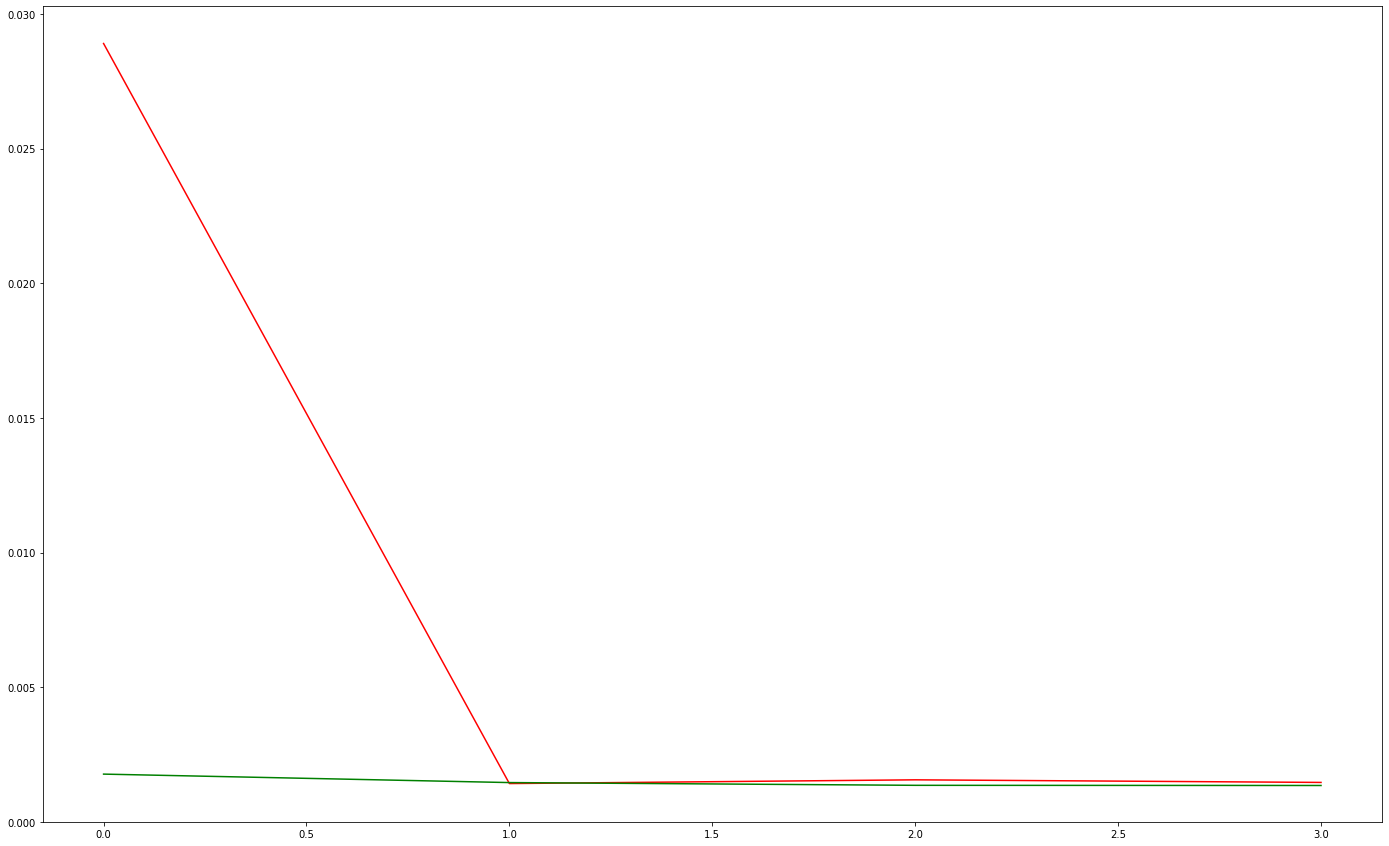

Train Epoch: 5 [0/4951 (0%)]	Loss: 0.000196
Train Epoch: 5 [160/4951 (3%)]	Loss: 0.000008
Train Epoch: 5 [320/4951 (6%)]	Loss: 0.000005
Train Epoch: 5 [480/4951 (10%)]	Loss: 0.000010
Train Epoch: 5 [640/4951 (13%)]	Loss: 0.000010
Train Epoch: 5 [800/4951 (16%)]	Loss: 0.000003
Train Epoch: 5 [960/4951 (19%)]	Loss: 0.000004
Train Epoch: 5 [1120/4951 (23%)]	Loss: 0.000003
Train Epoch: 5 [1280/4951 (26%)]	Loss: 0.000030
Train Epoch: 5 [1440/4951 (29%)]	Loss: 0.224353
Train Epoch: 5 [1600/4951 (32%)]	Loss: 0.000010
Train Epoch: 5 [1760/4951 (35%)]	Loss: 0.000016
Train Epoch: 5 [1920/4951 (39%)]	Loss: 0.000051
Train Epoch: 5 [2080/4951 (42%)]	Loss: 0.000031
Train Epoch: 5 [2240/4951 (45%)]	Loss: 0.000043
Train Epoch: 5 [2400/4951 (48%)]	Loss: 0.000002
Train Epoch: 5 [2560/4951 (52%)]	Loss: 0.000182
Train Epoch: 5 [2720/4951 (55%)]	Loss: 0.000025
Train Epoch: 5 [2880/4951 (58%)]	Loss: 0.000038
Train Epoch: 5 [3040/4951 (61%)]	Loss: 0.000008
Train Epoch: 5 [3200/4951 (65%)]	Loss: 0.000010
Trai

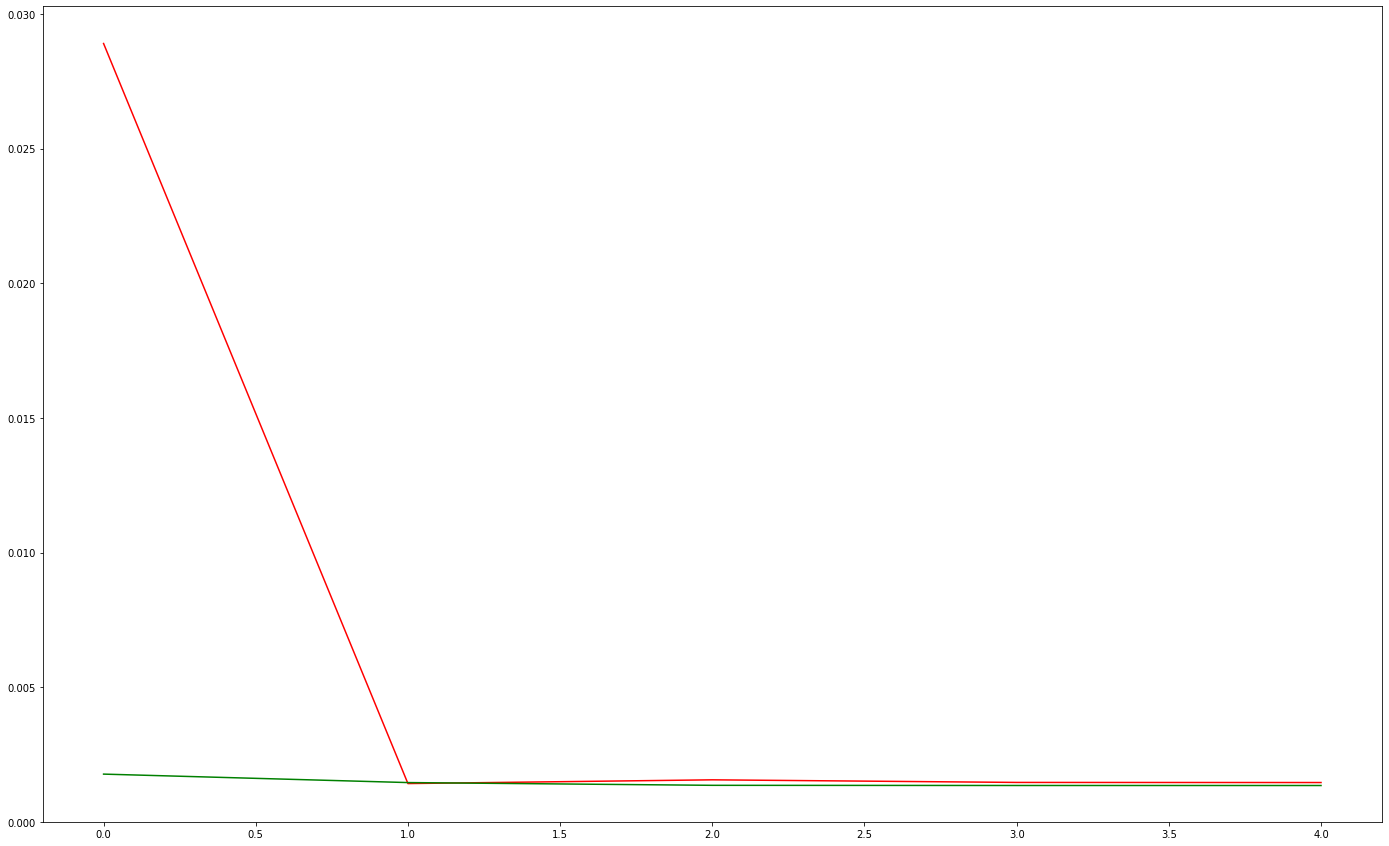

Train Epoch: 6 [0/4951 (0%)]	Loss: 0.000011
Train Epoch: 6 [160/4951 (3%)]	Loss: 0.000010
Train Epoch: 6 [320/4951 (6%)]	Loss: 0.000059
Train Epoch: 6 [480/4951 (10%)]	Loss: 0.000111
Train Epoch: 6 [640/4951 (13%)]	Loss: 0.000010
Train Epoch: 6 [800/4951 (16%)]	Loss: 0.000400
Train Epoch: 6 [960/4951 (19%)]	Loss: 0.000001
Train Epoch: 6 [1120/4951 (23%)]	Loss: 0.000006
Train Epoch: 6 [1280/4951 (26%)]	Loss: 0.000059
Train Epoch: 6 [1440/4951 (29%)]	Loss: 0.000930
Train Epoch: 6 [1600/4951 (32%)]	Loss: 0.000080
Train Epoch: 6 [1760/4951 (35%)]	Loss: 0.000010
Train Epoch: 6 [1920/4951 (39%)]	Loss: 0.000014
Train Epoch: 6 [2080/4951 (42%)]	Loss: 0.000009
Train Epoch: 6 [2240/4951 (45%)]	Loss: 0.000005
Train Epoch: 6 [2400/4951 (48%)]	Loss: 0.000131
Train Epoch: 6 [2560/4951 (52%)]	Loss: 0.000015
Train Epoch: 6 [2720/4951 (55%)]	Loss: 0.000011
Train Epoch: 6 [2880/4951 (58%)]	Loss: 0.000008
Train Epoch: 6 [3040/4951 (61%)]	Loss: 0.000007
Train Epoch: 6 [3200/4951 (65%)]	Loss: 0.000007
Trai

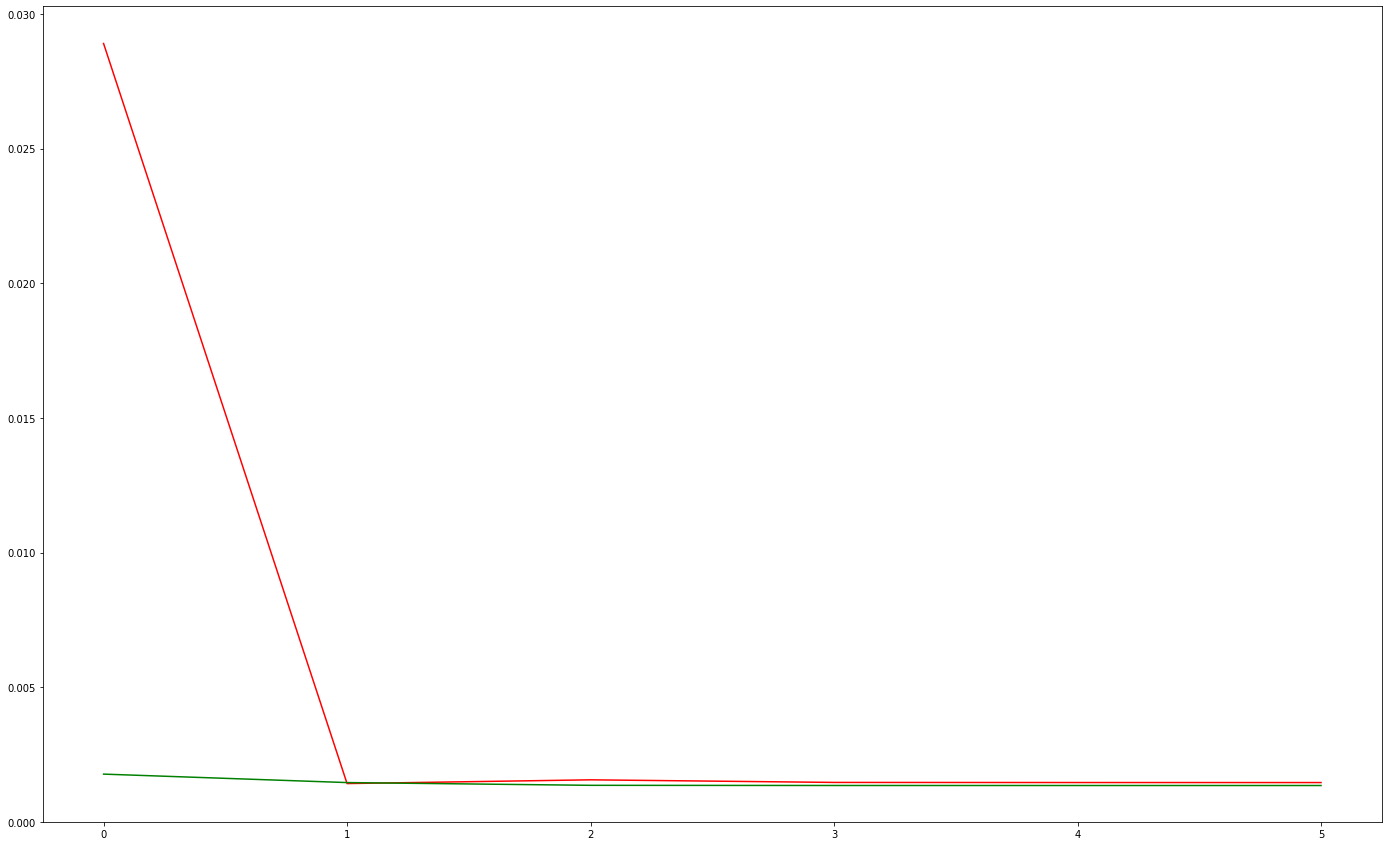

Train Epoch: 7 [0/4951 (0%)]	Loss: 0.000005
Train Epoch: 7 [160/4951 (3%)]	Loss: 0.000011
Train Epoch: 7 [320/4951 (6%)]	Loss: 0.000023
Train Epoch: 7 [480/4951 (10%)]	Loss: 0.000010
Train Epoch: 7 [640/4951 (13%)]	Loss: 0.000016
Train Epoch: 7 [800/4951 (16%)]	Loss: 0.000173
Train Epoch: 7 [960/4951 (19%)]	Loss: 0.000004
Train Epoch: 7 [1120/4951 (23%)]	Loss: 0.000160
Train Epoch: 7 [1280/4951 (26%)]	Loss: 0.000005
Train Epoch: 7 [1440/4951 (29%)]	Loss: 0.000021
Train Epoch: 7 [1600/4951 (32%)]	Loss: 0.000071
Train Epoch: 7 [1760/4951 (35%)]	Loss: 0.000002
Train Epoch: 7 [1920/4951 (39%)]	Loss: 0.000304
Train Epoch: 7 [2080/4951 (42%)]	Loss: 0.000019
Train Epoch: 7 [2240/4951 (45%)]	Loss: 0.000328
Train Epoch: 7 [2400/4951 (48%)]	Loss: 0.000040
Train Epoch: 7 [2560/4951 (52%)]	Loss: 0.000037
Train Epoch: 7 [2720/4951 (55%)]	Loss: 0.000014
Train Epoch: 7 [2880/4951 (58%)]	Loss: 0.000011
Train Epoch: 7 [3040/4951 (61%)]	Loss: 0.000018
Train Epoch: 7 [3200/4951 (65%)]	Loss: 0.000005
Trai

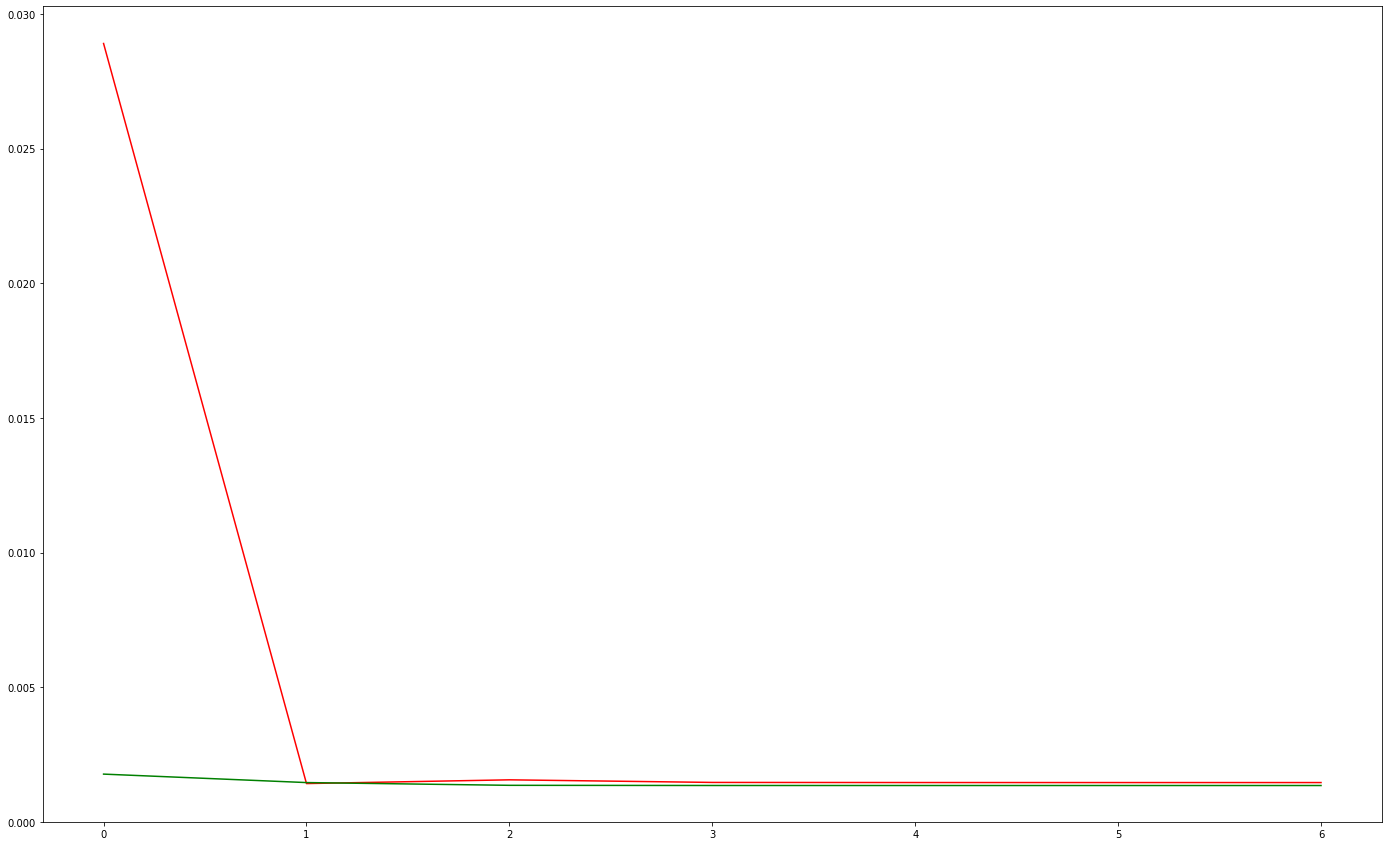

Train Epoch: 8 [0/4951 (0%)]	Loss: 0.000010
Train Epoch: 8 [160/4951 (3%)]	Loss: 0.000011
Train Epoch: 8 [320/4951 (6%)]	Loss: 0.000003
Train Epoch: 8 [480/4951 (10%)]	Loss: 0.000021
Train Epoch: 8 [640/4951 (13%)]	Loss: 0.000021
Train Epoch: 8 [800/4951 (16%)]	Loss: 0.000017
Train Epoch: 8 [960/4951 (19%)]	Loss: 0.000054
Train Epoch: 8 [1120/4951 (23%)]	Loss: 0.000084
Train Epoch: 8 [1280/4951 (26%)]	Loss: 0.000107
Train Epoch: 8 [1440/4951 (29%)]	Loss: 0.000022
Train Epoch: 8 [1600/4951 (32%)]	Loss: 0.000035
Train Epoch: 8 [1760/4951 (35%)]	Loss: 0.000037
Train Epoch: 8 [1920/4951 (39%)]	Loss: 0.000027
Train Epoch: 8 [2080/4951 (42%)]	Loss: 0.000008
Train Epoch: 8 [2240/4951 (45%)]	Loss: 0.000002
Train Epoch: 8 [2400/4951 (48%)]	Loss: 0.000017
Train Epoch: 8 [2560/4951 (52%)]	Loss: 0.000014
Train Epoch: 8 [2720/4951 (55%)]	Loss: 0.000005
Train Epoch: 8 [2880/4951 (58%)]	Loss: 0.000099
Train Epoch: 8 [3040/4951 (61%)]	Loss: 0.000060
Train Epoch: 8 [3200/4951 (65%)]	Loss: 0.000005
Trai

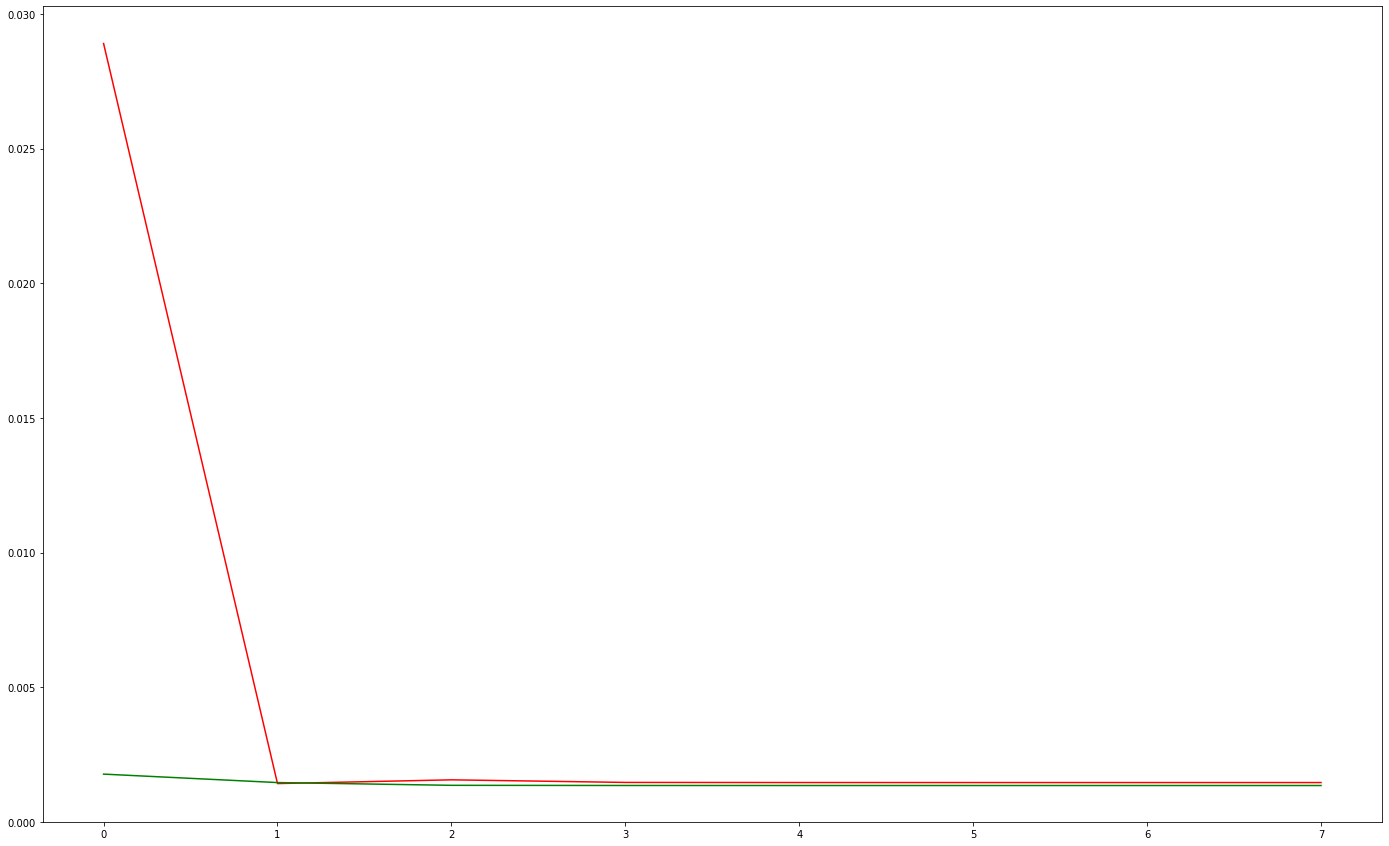

Train Epoch: 9 [0/4951 (0%)]	Loss: 0.000018
Train Epoch: 9 [160/4951 (3%)]	Loss: 0.000049
Train Epoch: 9 [320/4951 (6%)]	Loss: 0.000186
Train Epoch: 9 [480/4951 (10%)]	Loss: 0.030709
Train Epoch: 9 [640/4951 (13%)]	Loss: 0.000057
Train Epoch: 9 [800/4951 (16%)]	Loss: 0.000003
Train Epoch: 9 [960/4951 (19%)]	Loss: 0.000027
Train Epoch: 9 [1120/4951 (23%)]	Loss: 0.000011
Train Epoch: 9 [1280/4951 (26%)]	Loss: 0.000015
Train Epoch: 9 [1440/4951 (29%)]	Loss: 0.000148
Train Epoch: 9 [1600/4951 (32%)]	Loss: 0.000029
Train Epoch: 9 [1760/4951 (35%)]	Loss: 0.000012
Train Epoch: 9 [1920/4951 (39%)]	Loss: 0.000015
Train Epoch: 9 [2080/4951 (42%)]	Loss: 0.000121
Train Epoch: 9 [2240/4951 (45%)]	Loss: 0.000449
Train Epoch: 9 [2400/4951 (48%)]	Loss: 0.000060
Train Epoch: 9 [2560/4951 (52%)]	Loss: 0.000076
Train Epoch: 9 [2720/4951 (55%)]	Loss: 0.000003
Train Epoch: 9 [2880/4951 (58%)]	Loss: 0.000005
Train Epoch: 9 [3040/4951 (61%)]	Loss: 0.000018
Train Epoch: 9 [3200/4951 (65%)]	Loss: 0.001226
Trai

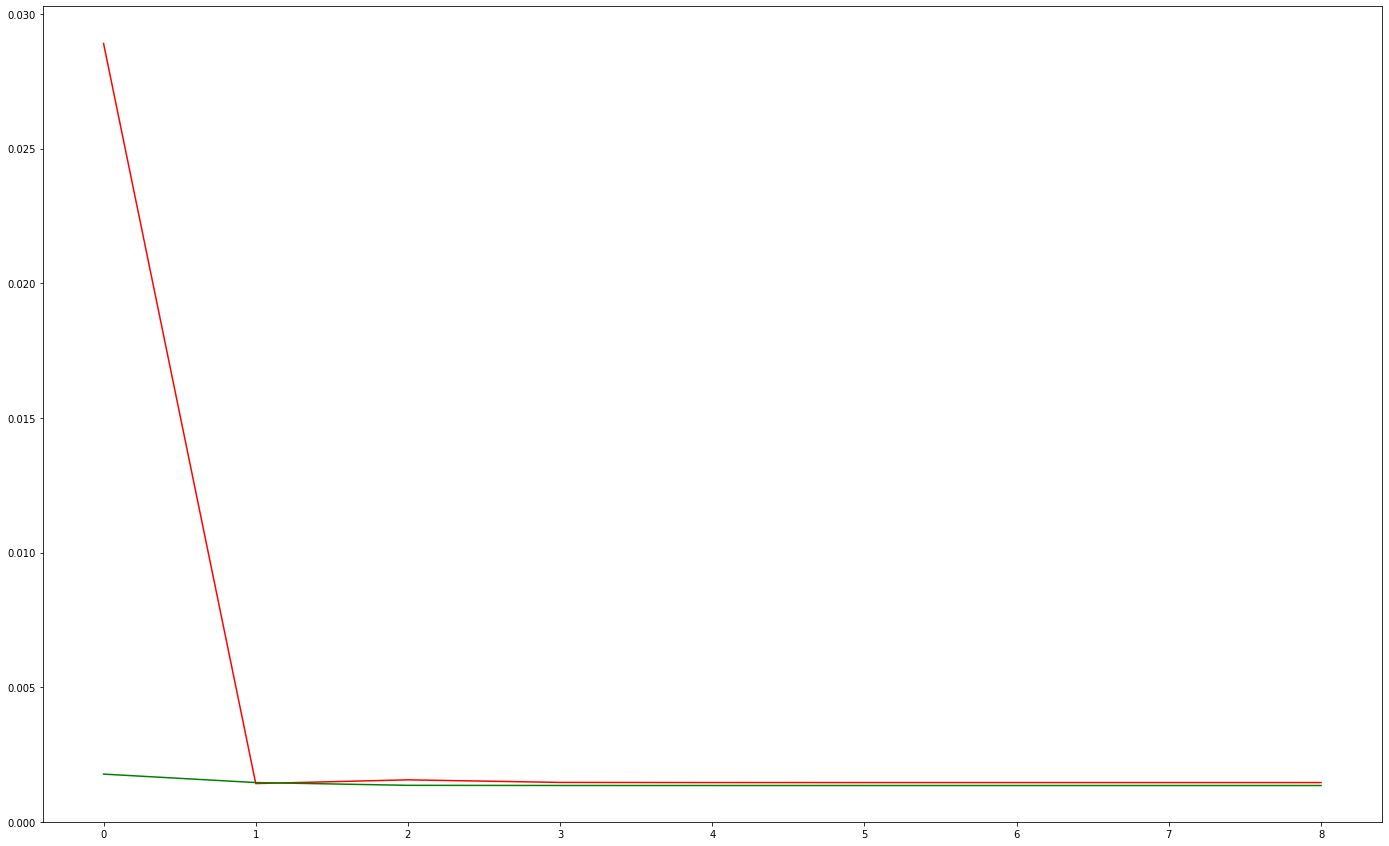

Train Epoch: 10 [0/4951 (0%)]	Loss: 0.000140
Train Epoch: 10 [160/4951 (3%)]	Loss: 0.000060
Train Epoch: 10 [320/4951 (6%)]	Loss: 0.000027
Train Epoch: 10 [480/4951 (10%)]	Loss: 0.000027
Train Epoch: 10 [640/4951 (13%)]	Loss: 0.000026
Train Epoch: 10 [800/4951 (16%)]	Loss: 0.000950
Train Epoch: 10 [960/4951 (19%)]	Loss: 0.000013
Train Epoch: 10 [1120/4951 (23%)]	Loss: 0.000007
Train Epoch: 10 [1280/4951 (26%)]	Loss: 0.000145
Train Epoch: 10 [1440/4951 (29%)]	Loss: 0.002894
Train Epoch: 10 [1600/4951 (32%)]	Loss: 0.000032
Train Epoch: 10 [1760/4951 (35%)]	Loss: 0.000015
Train Epoch: 10 [1920/4951 (39%)]	Loss: 0.000017
Train Epoch: 10 [2080/4951 (42%)]	Loss: 0.000036
Train Epoch: 10 [2240/4951 (45%)]	Loss: 0.000025
Train Epoch: 10 [2400/4951 (48%)]	Loss: 0.000017
Train Epoch: 10 [2560/4951 (52%)]	Loss: 0.000072
Train Epoch: 10 [2720/4951 (55%)]	Loss: 0.000010
Train Epoch: 10 [2880/4951 (58%)]	Loss: 0.000044
Train Epoch: 10 [3040/4951 (61%)]	Loss: 0.000005
Train Epoch: 10 [3200/4951 (65%)

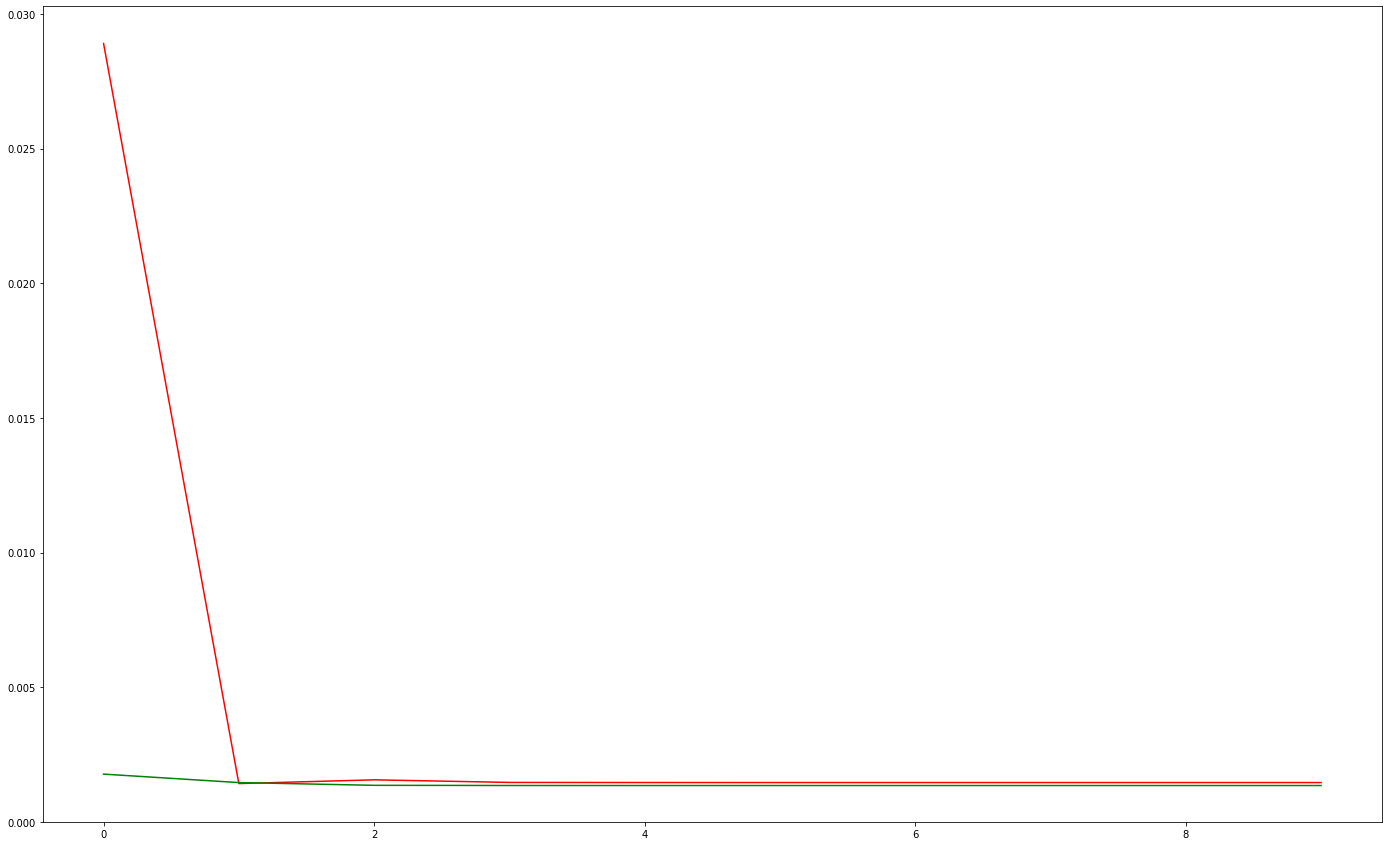

In [ ]:
epochs          = 10
lr              = 1
gamma           = 0.1
seed            = 1
log_interval    = 10

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")


model = Conv_net().to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    test(model, device, test_loader, test_loss)
    scheduler.step()

    plt.figure(figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

In [ ]:
from torchsummary import summary
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
            Conv2d-2           [-1, 32, 32, 32]           4,640
            Linear-3                    [-1, 3]           6,147
Total params: 10,947
Trainable params: 10,947
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.04
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


In [ ]:
# Save
torch.save(model.state_dict(), "model.pth")